# Chapter 6 - Evolutionary Algorithms
### Deep Reinforcement Learning *in Action*

# Section 6.2 

##### Listing 6.1

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.! " #1: the list of characters we sample from to produce random strings
target = "Hello World!" #2: target string; evlove from a random population

class Individual: #3: a simple case to store information about individual of the population
    def __init__(self, string, fitness=0):
        self.string = string    # string value
        self.fitness = fitness  # fitness score

from difflib import SequenceMatcher

def similar(a, b): #4: compute fitness (similarity between two strings)
    return SequenceMatcher(None, a, b).ratio()

def spawn_population(length=26,size=100): #5: produce an initial random population; e.g., string length of 26, population of 100
    pop = []
    for i in range(size):
        string = ''.join(random.choices(alphabet,k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop

##### Listing 6.2

In [2]:
def recombine(p1_, p2_): #1: recombines two parent strings into two new children/offsprings
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []
    cross_pt = random.randint(0,len(p1))
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])
    c1 = Individual(''.join(child1))
    c2 = Individual(''.join(child2))
    return c1, c2

def mutate(x, mut_rate=0.01): #2: mutate a child's string value by random
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x_.extend(random.choices(alphabet,k=1))
        else:
            new_x_.append(char)
    new_x = Individual(''.join(new_x_))
    return new_x

##### Listing 6.3

In [3]:
def evaluate_population(pop, target): #1: assigns a fitness score to each individual in the population
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

def next_generation(pop, size=100, length=26, mut_rate=0.01): #2: generates a new generation by recombination and mutation
    new_pop = []
    while len(new_pop) < size:
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0],parents[1])
        child1 = mutate(offspring_[0], mut_rate=mut_rate)
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

##### Listing 6.4

In [30]:
num_generations = 150
population_size = 900
str_len = len(target)
mutation_rate = 0.00001 #1: set the mutation rate to 0.1%

pop_fit = []
pop = spawn_population(size=population_size, length=str_len) #2: create the initial random population
done = False
for gen in range(num_generations):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit) #3: record the population's average fitness over training time
    new_pop = next_generation(pop, \
        size=population_size, length=str_len, mut_rate=mutation_rate)
    pop = new_pop
    for x in pop: 
        if x.string == target: 
            print("Target Found!")
            done = True
    if done:
        break

In [32]:
pop.sort(key=lambda x: x.fitness, reverse=True) #sort in place, highest fitness first
pop[0].string

'HellMoo Wor!'

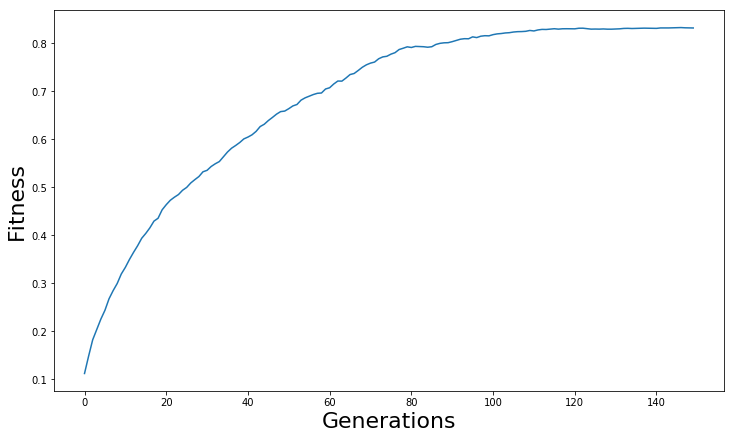

In [33]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Fitness",fontsize=22)
plt.plot(pop_fit)

# Section 6.3 

##### Listing 6.5
CartPole Example

In [13]:
import random
import numpy as np
from matplotlib import pyplot as plt

In [1]:
import torch

Total number of parameters: $4*25 + 25 + 10*25 + 10 + 2*10 + 2 = 407$

In [2]:
# defining an agent as a neural network model
def model(x,unpacked_params):
    l1,b1,l2,b2,l3,b3 = unpacked_params #1: unpack the parameter vector into individual layer matrices
    y = torch.nn.functional.linear(x,l1,b1) #2: simple linear layer with bias
    y = torch.relu(y) #3: rectified linear unit activation
    y = torch.nn.functional.linear(y,l2,b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y,l3,b3)
    y = torch.log_softmax(y,dim=0) #4: sofmax -> log-probabilities of actions
    return y

##### Listing 6.6

In [4]:
def unpack_params(params, layers=[(25,4),(10,25),(2,10)]): #1: specifies the shape of each layer
    unpacked_params = [] #2: store each individual layer tensor
    e = 0
    for i,l in enumerate(layers): #3: iterate through each layer
        s,e = e,e+np.prod(l)
        weights = params[s:e].view(l) #4: unpack the individual layer into matrix
        s,e = e,e+l[0]
        bias = params[s:e]
        unpacked_params.extend([weights,bias]) #5: add the unpacked tensor to the list
    return unpacked_params


##### Listing 6.7

In [3]:
def spawn_population(N=50,size=407): #1: N=size of population; size=length of the parameter vectors
    pop = []
    for i in range(N):
        vec = torch.randn(size) / 2.0 #2: randomly initialized param vector
        fit = 0
        p = {'params':vec, 'fitness':fit} #3: a dictionary to store the param vector and its fitness score
        pop.append(p)
    return pop

##### Listing 6.8

In [6]:
def recombine(x1,x2): #1: combines x1 and x2 agents (in: dict) to create children agents
    x1 = x1['params'] #2: extract parameters
    x2 = x2['params']
    l = x1.shape[0]
    split_pt = np.random.randint(l) #3: split/crossover point (randomly produced)
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    child1[0:split_pt] = x1[0:split_pt] #4: child1 = p1+p2; child2 = p2+p1
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = {'params':child1, 'fitness': 0.0} #5: create new children agents with new parameters 
    c2 = {'params':child2, 'fitness': 0.0}
    return c1, c2

##### Listing 6.9

In [5]:
def mutate(x, rate=0.01): #1: mutation rate of 0.01 (1%)
    x_ = x['params']
    num_to_change = int(rate * x_.shape[0]) #2: decide how many parameter vector elements to mutate
    idx = np.random.randint(low=0,high=x_.shape[0],size=(num_to_change,))
    x_[idx] = torch.randn(num_to_change) / 10.0 #3: randomly resets the selected parameter elements
    x['params'] = x_
    return x

##### Listing 6.10

In [7]:
import gym
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/unam9su/.local/share/virtualenvs/DeepReinforcementLearningInAction-fvkxvmmz/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
def test_model(agent):
    done = False
    state = torch.from_numpy(env.reset()).float()
    score = 0
    while not done: #1: while game is not lost
        params = unpack_params(agent['params'])
        probs = model(state,params) #2: get the action probabilities from the model using the agent's parameter vec
        action = torch.distributions.Categorical(probs=probs).sample() #3: probabilistically select an action by sampling from a categorical dist. 
        state_, reward, done, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1 #4: add a score since the game is not lost
    return score

##### Listing 6.11

In [9]:
def evaluate_population(pop):
    tot_fit = 0 #1: total fitness for this population
    lp = len(pop)
    for agent in pop: #2: iterate through each agent from the population
        score = test_model(agent) #3: run the agent in the environment
        agent['fitness'] = score #4: store the fitness value
        tot_fit += score
    avg_fit = tot_fit / lp
    return pop, avg_fit

##### Listing 6.12

In [10]:
def next_generation(pop,mut_rate=0.001,tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop): #1: while the new population is not full
        rids = np.random.randint(low=0,high=lp,size=(int(tournament_size*lp))) #2: select a percentage of the full population as a subset
        batch = np.array([[i,x['fitness']] for (i,x) in enumerate(pop) if i in rids]) #3: subset the population to get a batch of agents -> match each one with their index value in the original population
        scores = batch[batch[:, 1].argsort()] #4: sort the batch ([[index, fitness score]]) in ascending order
        i0, i1 = int(scores[-1][0]),int(scores[-2][0]) #5: select the 2 last (highest scored) agents in the sorted batch
        parent0,parent1 = pop[i0],pop[i1]
        offspring_ = recombine(parent0,parent1) #6: recombine the parents to get offspring
        child1 = mutate(offspring_[0], rate=mut_rate) #7: mutate the children before putting them into the next gen
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

##### Listing 6.13

In [20]:
num_generations = 20 #1: number of generations to evlove
population_size = 1000 #2: the number of individuals in each gen
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size,size=407) #3: initialize a population
for i in range(num_generations):
    pop, avg_fit = evaluate_population(pop) #4: evaluate the fitness of each agent in population
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate,tournament_size=0.2) #5: populate the next gen

In [21]:
def running_mean(x,n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0]-n)
    for i in range(x.shape[0]-n):
        y[i] = (conv @ x[i:i+n]) / n
    return y

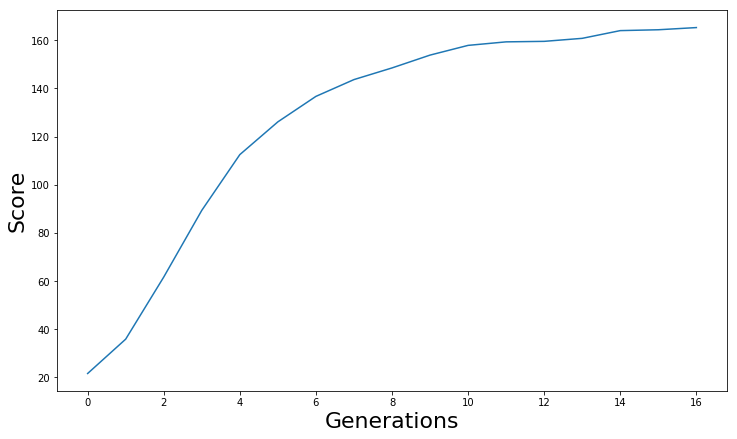

In [22]:
plt.figure(figsize=(12,7))
plt.xlabel("Generations",fontsize=22)
plt.ylabel("Score",fontsize=22)
plt.plot(running_mean(np.array(pop_fit),3))

In [24]:
test_model(pop[1])

113